Calculate flux dependence on zenith and/or atmosphere
-----------------------------------------------------

This notebook creates *Figure 5* from the proceedings. http://inspirehep.net/record/1346929 The result may be slightly different since MCEq evolved over time.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from MCEq.core import MCEqRun
import crflux.models as pm
import mceq_config as config

Initialize the `mceq_run` object
--------------------------------

In [2]:
mceq_run = MCEqRun(
    interaction_model="SIBYLL2.3d",
    primary_model=(pm.HillasGaisser2012, "H3a"),
    theta_deg=0.0,
)

MCEqRun::set_interaction_model(): SIBYLL23D
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


In [3]:
from MCEq.ddm import DataDrivenModel
from os.path import join

ddm = DataDrivenModel(join(config.data_dir, "DDM_1.0.npy"))
mceq_run.inject_ddm(ddm)

DataDrivenModel::ddm_matrices(): Generating 2212 -> 2112 DDM matrix
DataDrivenModel::ddm_matrices(): Generating -211 -> -2212 DDM matrix
DataDrivenModel::ddm_matrices(): Generating 2212 -> 2212 DDM matrix
DataDrivenModel::ddm_matrices(): Generating -211 -> -211 DDM matrix
DataDrivenModel::ddm_matrices(): Generating 2212 -> -321 DDM matrix
DataDrivenModel::ddm_matrices(): Generating -211 -> 211 DDM matrix
DataDrivenModel::ddm_matrices(): Generating 2212 -> -211 DDM matrix
DataDrivenModel::ddm_matrices(): Generating -211 -> 2212 DDM matrix
DataDrivenModel::ddm_matrices(): Generating -211 -> 321 DDM matrix
DataDrivenModel::ddm_matrices(): Generating -211 -> -321 DDM matrix
DataDrivenModel::ddm_matrices(): Generating 2212 -> -2212 DDM matrix
DataDrivenModel::ddm_matrices(): Generating 2212 -> 211 DDM matrix
DataDrivenModel::ddm_matrices(): Generating 2212 -> 321 DDM matrix


Define what to calculate
------------------------

This example will calculate the flux for 5 different atmospheric profiles and 2 zenith angles. Zenith of 0 means vertical and 90 horizontal respectively. Note that the more inclide the shower trajectory is, the more integration steps *(read: calculation time)* are necessary. The total (conventional + prompt) fluxes will be stored in the `*_dict` dictionaries for plotting in the next step.

In [4]:
mup_dict, numu_dict, nue_dict = {}, {}, {}
for atm_tup in [
    (("CORSIKA", ("PL_SouthPole", "January")), "red"),
    (("CORSIKA", ("PL_SouthPole", "August")), "lightblue"),
    (("MSIS00", ("SouthPole", "January")), "darkred"),
    (("MSIS00", ("SouthPole", "August")), "blue"),
    (("CORSIKA", ("BK_USStd", None)), "black"),
]:
    mceq_run.set_density_model(atm_tup[0])
    for theta in [0.0, 90.0]:
        mceq_run.set_theta_deg(theta)
        mceq_run.solve()

        mag = 3

        mup_dict[(theta, atm_tup)] = mceq_run.get_solution(
            "total_mu+", mag
        ) + mceq_run.get_solution("total_mu-", mag)

        numu_dict[(theta, atm_tup)] = mceq_run.get_solution(
            "total_numu", mag
        ) + mceq_run.get_solution("total_antinumu", mag)

        nue_dict[(theta, atm_tup)] = mceq_run.get_solution(
            "total_nue", mag
        ) + mceq_run.get_solution("total_antinue", mag)

MCEqRun::set_density_model(): Setting density profile to CORSIKA ('PL_SouthPole', 'January')
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('PL_SouthPole', 'August')
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('SouthPole', 'January')
MCEqRun::set_density_model(): Setting density profile to MSIS00 ('SouthPole', 'August')
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)


Plot with `matplotlib`
----------------------

In [5]:
mup_dict.keys()

dict_keys([(0.0, (('CORSIKA', ('PL_SouthPole', 'January')), 'red')), (90.0, (('CORSIKA', ('PL_SouthPole', 'January')), 'red')), (0.0, (('CORSIKA', ('PL_SouthPole', 'August')), 'lightblue')), (90.0, (('CORSIKA', ('PL_SouthPole', 'August')), 'lightblue')), (0.0, (('MSIS00', ('SouthPole', 'January')), 'darkred')), (90.0, (('MSIS00', ('SouthPole', 'January')), 'darkred')), (0.0, (('MSIS00', ('SouthPole', 'August')), 'blue')), (90.0, (('MSIS00', ('SouthPole', 'August')), 'blue')), (0.0, (('CORSIKA', ('BK_USStd', None)), 'black')), (90.0, (('CORSIKA', ('BK_USStd', None)), 'black'))])

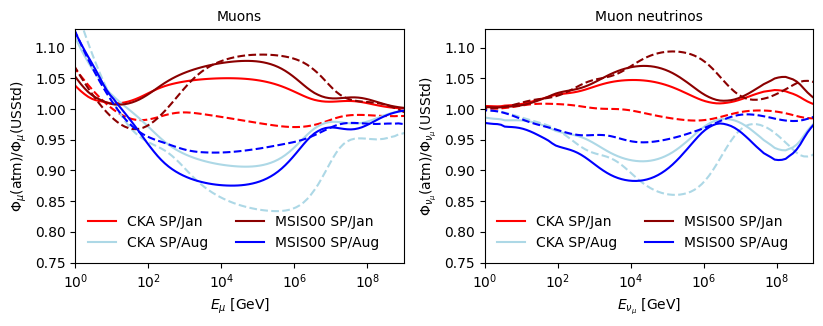

In [7]:
color_spectrum = [
    "b",
    "r",
    "g",
    "orange",
    "cyan",
    "violet",
    "brown",
    "pink",
    "yellow",
    "lightblue",
]
titles = {
    ("CORSIKA", ("PL_SouthPole", "January")): "CKA SP/Jan",
    ("CORSIKA", ("PL_SouthPole", "August")): "CKA SP/Aug",
    ("MSIS00", ("SouthPole", "January")): "MSIS00 SP/Jan",
    ("MSIS00", ("SouthPole", "August")): "MSIS00 SP/Aug",
    ("CORSIKA", ("BK_USStd", None)): "USStd",
}

fig = plt.figure(figsize=(8.5, 3.5))
fig.set_tight_layout(dict(rect=[0.01, 0.01, 0.99, 0.97]))
e_grid = mceq_run.e_grid

# Define base line
compare_to = (("CORSIKA", ("BK_USStd", None)), "black")

for theta, atm_tup in mup_dict.keys():
    atm_config, atm_col = atm_tup

    if atm_config[1][0].startswith("BK"):
        continue

    mup_comp = mup_dict[(theta, compare_to)]
    numu_comp = numu_dict[(theta, compare_to)]
    nue_comp = nue_dict[(theta, compare_to)]

    ls = "--"
    atm_title = "_nolabel_"
    if theta < 90.0:
        ls = "-"
        atm_title = titles[atm_config]

    plt.subplot(121)
    plt.plot(
        e_grid,
        mup_dict[(theta, atm_tup)] / mup_comp,
        ls=ls,
        lw=1.5,
        color=atm_col,
        label=atm_title,
    )
    plt.semilogx()
    plt.xlabel(r"$E_{\mu}$ [GeV]")
    plt.ylim([0.75, 1.1])

    plt.subplot(122)
    plt.plot(
        e_grid,
        numu_dict[(theta, atm_tup)] / numu_comp,
        ls=ls,
        lw=1.5,
        color=atm_col,
        label=atm_title,
    )
    plt.semilogx()
    plt.xlabel(r"$E_{\nu}$ [GeV]")


plt.subplot(121)
plt.title("Muons", fontsize=10)
plt.xlabel(r"$E_{\mu}$ [GeV]")
plt.ylabel(r"$\Phi_{\mu}($atm$)/\Phi_{\mu}($USStd)")
plt.xlim([1, 1e9])
plt.ylim([0.75, 1.13])
plt.legend(loc="lower left", ncol=2, frameon=False, fontsize=10)

plt.subplot(122)
plt.title("Muon neutrinos", fontsize=10)
plt.xlabel(r"$E_{\nu_\mu}$ [GeV]")
plt.ylabel(r"$\Phi_{\nu_\mu}($atm$)/\Phi_{\nu_\mu}($USStd)")
plt.xlim([1, 1e9])
plt.ylim([0.75, 1.13])
plt.legend(loc="lower left", ncol=2, frameon=False, fontsize=10)
# plt.savefig('atm_flux.pdf')